In [113]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(handle="nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

path_energy = path + "/energy_dataset.csv"
path_weather = path + "/weather_features.csv"

# Load the datasets
import pandas as pd

energy_df = pd.read_csv(path_energy)
weather_df = pd.read_csv(path_weather)

Path to dataset files: /Users/pascaltrosch/.cache/kagglehub/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/versions/1


In [114]:
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df = energy_df.set_index('time')

weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)
weather_df = weather_df.set_index('dt_iso')

In [115]:
energy_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [116]:
weather_df.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [117]:
# Replace total load actual with that rows total load forecast (Since thre are missing values)
energy_df['total load actual'].fillna(energy_df['total load forecast'], inplace=True)

/var/folders/9q/fdv3t0bs3vq9blwqqzpb7r240000gn/T/ipykernel_32004/2380757125.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  energy_df['total load actual'].fillna(energy_df['total load forecast'], inplace=True)


In [118]:
# Statistics of energy dataset
print("Energy dataset statistics:")
print(energy_df.describe())

# Statistics of weather dataset
print("Weather dataset statistics:")
print(weather_df.describe())

Energy dataset statistics:
       generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                          

# Merge two Datasets

In [119]:
def join_energy_weather(energy_df, weather_df, how='inner'):
   
    # Ensure both indices are datetime
    energy_df.index = pd.to_datetime(energy_df.index)
    weather_df.index = pd.to_datetime(weather_df.index)
    
    # Join on index (timestamp)
    combined_df = energy_df.join(weather_df, how=how, lsuffix='_energy', rsuffix='_weather')
    
    return combined_df

# Join the datasets
combined_df = join_energy_weather(energy_df, weather_df, how='inner')

print(f"Energy data shape: {energy_df.shape}")
print(f"Weather df shape: {weather_df.shape}")
print(f"Combined data shape: {combined_df.shape}")
print(f"\nDate range: {combined_df.index.min()} to {combined_df.index.max()}")
print(f"\nColumns in combined dataset:")
print(combined_df.columns.tolist())


Energy data shape: (35064, 28)
Weather df shape: (178396, 16)
Combined data shape: (178396, 44)

Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00

Columns in combined dataset:
['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 

# Create Population Average Factors

In [120]:
#Population Spain (Source: Wikipedia)
pct_spain=48590000/100
# Factor Madrid
pct_madrid=(3340176/pct_spain)/100
# Factor Barcelona
pct_barcelona=(1655956/pct_spain)/100
# Factor Valencia
pct_valencia=(804121/pct_spain)/100
# Factor Sevilla
pct_sevilla=(654164/pct_spain)/100
# Factor Bilbao
pct_bilbao=(345235/pct_spain)/100


print(pct_madrid, pct_barcelona, pct_valencia, pct_sevilla, pct_bilbao)

0.06874204568841326 0.03408018110722371 0.016549104754064622 0.013462934760238732 0.007105062770117309


In [121]:
# Remove leading and trailing spaces from 'city_name' column
combined_df['city_name'] = combined_df['city_name'].str.strip()

# Now, check the dataframe to see if the spaces are removed
print(combined_df['city_name'].unique())  # To see unique city names and verify


['Valencia' 'Madrid' 'Bilbao' 'Barcelona' 'Seville']


# Add Population Factors as Rows to Dataset

In [122]:
import pandas as pd

# Assuming combined_df is your DataFrame and it already contains columns 'city_name', 'total load actual', and 'total load forecast'

# Define city factors
city_factors = {
    "Madrid": pct_madrid,
    "Barcelona": pct_barcelona,
    "Valencia": pct_valencia,
    "Seville": pct_sevilla,
    "Bilbao": pct_bilbao
}

# Create a new column 'city_factor' based on 'city_name' by mapping the respective factors
combined_df['city_factor'] = combined_df['city_name'].map(city_factors)

# Now multiply 'total load actual' and 'total load forecast' by the city-specific factor
combined_df['total load actual adjusted'] = combined_df['total load actual'] * combined_df['city_factor']
combined_df['total load forecast adjusted'] = combined_df['total load forecast'] * combined_df['city_factor']

# Optionally, drop the temporary 'city_factor' column if you no longer need it
combined_df.drop(columns=['city_factor'], inplace=True)

# Print the adjusted dataframe
print(combined_df.head())

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2014-12-31 23:00:00+00:00               447.0   
2014-12-31 23:00:00+00:00               447.0   
2014-12-31 23:00:00+00:00               447.0   
2014-12-31 23:00:00+00:00               447.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2014-12-31 23:00:00+00:00                                 329.0   
2014-12-31 23:00:00+00:00                                 329.0   
2014-12-31 23:00:00+00:00                                 329.0   
2014-12-31 23:00:00+00:00                                 329.0   

                           generation fossil coal-derived gas  \
time                                                            
2014-12-31 23:00:00+00:00                               

# Explore new Dataset

In [123]:
combined_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,total load actual adjusted,total load forecast adjusted
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0,800,clear,sky is clear,01n,420.099024,432.229518
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0,800,clear,sky is clear,01n,1745.016830,1795.404749
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0,800,clear,sky is clear,01,180.362018,185.570029
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0,800,clear,sky is clear,01n,865.125397,890.106170
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0,800,clear,sky is clear,01n,341.756599,351.624930


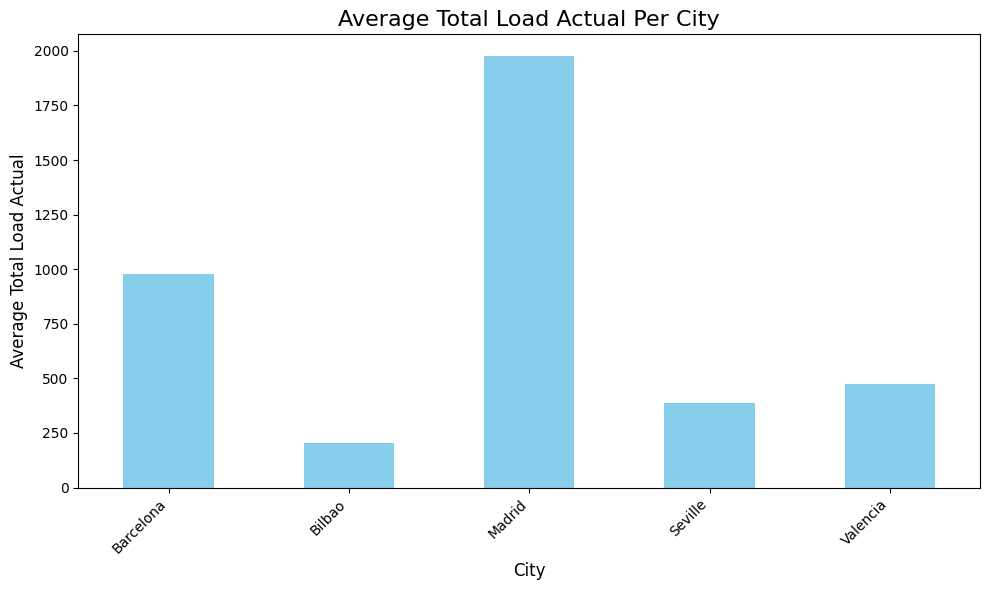

In [124]:
import matplotlib.pyplot as plt

# Calculate the average total load actual per city
avg_load_per_city = combined_df.groupby('city_name')['total load actual adjusted'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
avg_load_per_city.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.title('Average Total Load Actual Per City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Average Total Load Actual', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


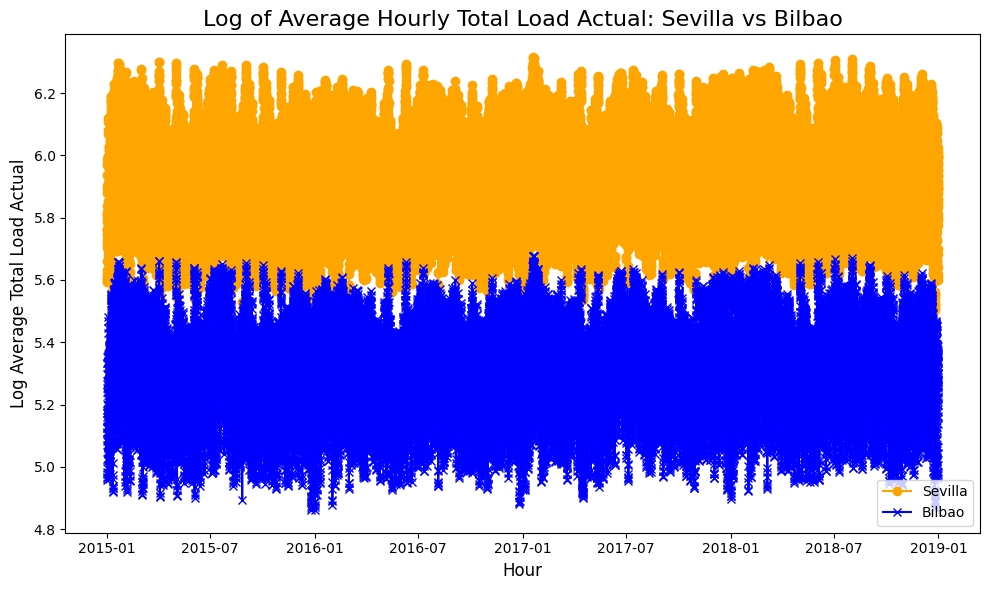

In [130]:
import numpy as np

# Filter data for Sevilla and Bilbao
sevilla_df = combined_df[combined_df['city_name'] == 'Seville']
bilbao_df = combined_df[combined_df['city_name'] == 'Bilbao']

# Group by hour and calculate the average total load actual for each city
# Assuming you have a 'hour' column to group by. If not, you'll need to extract it from a datetime column
sevilla_avg_hourly = sevilla_df.groupby("time")['total load actual adjusted'].mean()
bilbao_avg_hourly = bilbao_df.groupby('time')['total load actual adjusted'].mean()

# Log-transform the average hourly load (adding 1 to avoid log(0) issues)
sevilla_log_avg_hourly = np.log1p(sevilla_avg_hourly)  # log(x + 1)
bilbao_log_avg_hourly = np.log1p(bilbao_avg_hourly)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(sevilla_log_avg_hourly, label='Sevilla', color='orange', marker='o')
plt.plot(bilbao_log_avg_hourly, label='Bilbao', color='blue', marker='x')

# Adding labels and title
plt.title('Log of Average Hourly Total Load Actual: Sevilla vs Bilbao', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Log Average Total Load Actual', fontsize=12)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()




# Data Pipeline

,time,year,month,hour,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,...,clouds_all,weather_id,weather_main,weather_description,weather_icon,total load actual adjusted,total load forecast adjusted,population_factor,weighted_load,weighted_population_mean
0,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,420.099024,432.229518,0.016549,6.952263,1159.605744
1,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,1745.016830,1795.404749,0.068742,119.956027,1159.605744
2,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01,180.362018,185.570029,0.007105,1.281483,1159.605744
3,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,865.125397,890.106170,0.034080,29.483630,1159.605744
4,2014-12-31 23:00:00+00:00,2014,12,23,447.0,329.0,0.0,4844.0,4821.0,162.0,...,0,800,clear,sky is clear,01n,341.756599,351.624930,0.013463,4.601047,1159.605744
